In [1]:
import numpy as np
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings


def kw_dunn(groups, to_compare=None, alpha=0.05, method='bonf'):
    """
    Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test
    Arguments:
    ---------------
    groups: sequence
        arrays corresponding to k mutually independent samples from
        continuous populations
    to_compare: sequence
        tuples specifying the indices of pairs of groups to compare, e.g.
        [(0, 1), (0, 2)] would compare group 0 with 1 & 2. by default, all
        possible pairwise comparisons between groups are performed.
    alpha: float
        family-wise error rate used for correcting for multiple comparisons
        (see statsmodels.stats.multitest.multipletests for details)
    method: string
        method used to adjust p-values to account for multiple corrections (see
        statsmodels.stats.multitest.multipletests for options)
    Returns:
    ---------------
    H: float
        Kruskal-Wallis H-statistic
    p_omnibus: float
        p-value corresponding to the global null hypothesis that the medians of
        the groups are all equal
    Z_pairs: float array
        Z-scores computed for the absolute difference in mean ranks for each
        pairwise comparison
    p_corrected: float array
        corrected p-values for each pairwise comparison, corresponding to the
        null hypothesis that the pair of groups has equal medians. note that
        these are only meaningful if the global null hypothesis is rejected.
    reject: bool array
        True for pairs where the null hypothesis can be rejected for the given
        alpha
    Reference:
    ---------------
    Gibbons, J. D., & Chakraborti, S. (2011). Nonparametric Statistical
    Inference (5th ed., pp. 353-357). Boca Raton, FL: Chapman & Hall.
    """

    # omnibus test (K-W ANOVA)
    # -------------------------------------------------------------------------

    groups = [np.array(gg) for gg in groups]

    k = len(groups)

    n = np.array([len(gg) for gg in groups])
    if np.any(n < 5):
        warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "
                      "a chi square distribution)")

    allgroups = np.concatenate(groups)
    N = len(allgroups)
    ranked = stats.rankdata(allgroups)

    # correction factor for ties
    T = stats.tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in kruskal')

    # sum of ranks for each group
    j = np.insert(np.cumsum(n), 0, 0)
    R = np.empty(k, dtype=np.float)
    for ii in range(k):
        R[ii] = ranked[j[ii]:j[ii + 1]].sum()

    # the Kruskal-Wallis H-statistic
    H = (12. / (N * (N + 1.))) * ((R ** 2.) / n).sum() - 3 * (N + 1)

    # apply correction factor for ties
    H /= T

    df_omnibus = k - 1
    p_omnibus = stats.chisqprob(H, df_omnibus)

    # multiple comparisons
    # -------------------------------------------------------------------------

    # by default we compare every possible pair of groups
    if to_compare is None:
        to_compare = tuple(combinations(range(k), 2))

    ncomp = len(to_compare)

    Z_pairs = np.empty(ncomp, dtype=np.float)
    p_uncorrected = np.empty(ncomp, dtype=np.float)
    Rmean = R / n

    for pp, (ii, jj) in enumerate(to_compare):

        # standardized score
        Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
               np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        Z_pairs[pp] = Zij

    # corresponding p-values obtained from upper quantiles of the standard
    # normal distribution
    p_uncorrected = stats.norm.sf(Z_pairs) * 2.

    # correction for multiple comparisons
    reject, p_corrected, alphac_sidak, alphac_bonf = multipletests(
        p_uncorrected, method=method
    )

    return H, p_omnibus, Z_pairs, p_corrected, reject

In [2]:
import matplotlib.pyplot as plt
import matplotlib
SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SIZE)                # controls default text sizes
plt.rc('axes', titlesize=SIZE)           # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)          # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)          # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)          # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title
%matplotlib inline

In [3]:
from scipy.io import loadmat

In [4]:
import pandas as pd

In [5]:
diff = loadmat('difference.mat')
diff = diff['difference_norm']

In [6]:
df = pd.DataFrame({'LI':diff.flatten(),'Group':np.repeat([1,2,3,4,5],20)})

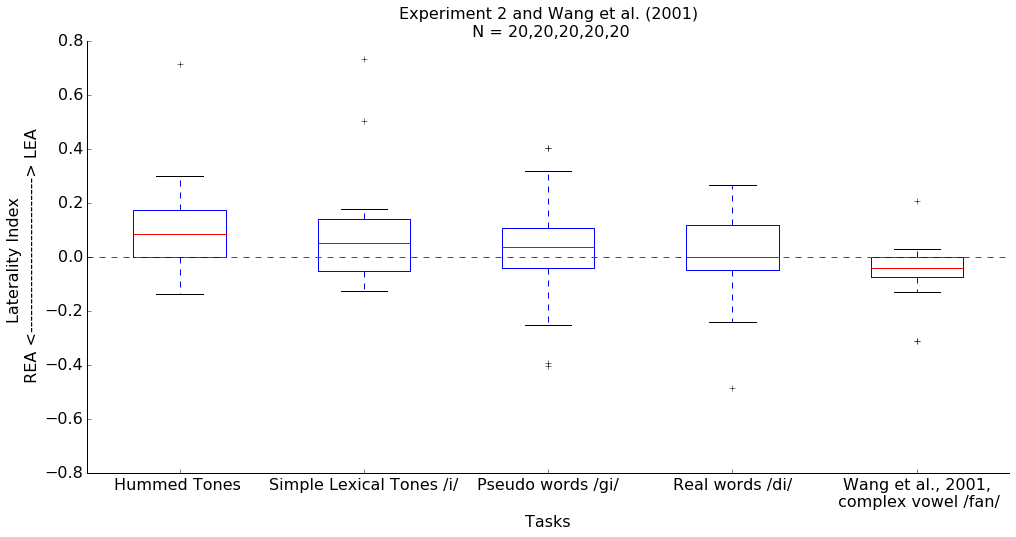

In [7]:
fig, ax = plt.subplots(figsize=(16,8))
ax=df.boxplot('LI',by='Group',ax=ax,fontsize=16,grid=False)
ax.set(title='Experiment 2 and Wang et al. (2001)\n N = 20,20,20,20,20',
      xticklabels=['Hummed Tones ','Simple Lexical Tones /i/','Pseudo words /gi/','Real words /di/\n',
                   'Wang et al., 2001,\n complex vowel /fan/'],
      ylabel='Laterality Index \n REA <---------------------------> LEA',xlabel='Tasks',
      ylim=(-0.8,0.8))

ax.axhline(0,color='red',linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.suptitle('')
fig.savefig('laterality index.png')

# comment:
I guess errorbar would be just fine, but in here it is easier to plot box plot. It is the same thing I showed you before.

# I did a Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test, which is the same as I did in Matlab

The difference is only significant between hummed tones and Wang's complex vowels. 

In [8]:
diff[:4,:].shape

(4, 20)

In [9]:
a,b,c,d,e=kw_dunn(diff,to_compare=[(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)])
print([(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)],d)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)] [ 1.          1.          1.          0.02113338  1.          1.
  0.19102812  1.          0.31336992  0.95372673]


In [10]:
print(a,b,c,d,e)

10.5774100055 0.0317472289336 [ 0.73030578  0.92105729  1.40611113  3.07382433  0.19075151  0.67580535
  2.34351855  0.48505384  2.15276704  1.6677132 ] [ 1.          1.          1.          0.02113338  1.          1.
  0.19102812  1.          0.31336992  0.95372673] [False False False  True False False False False False False]


# I also did a 1-way ANOVA, which is not significant 

In [18]:
stats.f_oneway(diff[0,:],diff[1,:],diff[2,:],diff[3,:],diff[4,:])

F_onewayResult(statistic=2.3604728677780611, pvalue=0.058764959449229721)

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
df['group'] = df.Group.map({1:'hum',2:'simple vowel',3:'non word',4:'real word',5:'comple vowel'})
mod = ols('LI ~ group',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,0.316883,4.0,2.360473,0.058765
Residual,3.188332,95.0,NaN,NaN


In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# So the multiple comparison after the ANOVA is not significant

In [12]:
mc = MultiComparison(df['LI'], df['Group'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.0206  -0.1817 0.1405 False 
  1      3    -0.0708  -0.2319 0.0903 False 
  1      4    -0.1009   -0.262 0.0602 False 
  1      5    -0.1569   -0.318 0.0042 False 
  2      3    -0.0502  -0.2113 0.1109 False 
  2      4    -0.0803  -0.2414 0.0808 False 
  2      5    -0.1363  -0.2974 0.0248 False 
  3      4    -0.0301  -0.1912 0.131  False 
  3      5    -0.0861  -0.2472 0.075  False 
  4      5     -0.056  -0.2171 0.1051 False 
--------------------------------------------
[1 2 3 4 5]


# I try what Xing said about two way ANOVA based on ears (left vs right) and tasks (4 in experiment 2 and Wang paper)

In [14]:
ears = loadmat('ears.mat')

In [15]:
grand_leftcol = ears['grand_leftCol']
grand_rightcol = ears['grand_rightCol']

In [33]:
from statsmodels.graphics.factorplots import interaction_plot

In [44]:
P = ['Hummed Tones ','Simple Lexical Tones /i/','Pseudo words /gi/','Real words /di/\n',
                   'Wang et al., 2001,\n complex vowel /fan/']
df = pd.DataFrame({'data':np.concatenate((grand_leftcol.flatten(),grand_rightcol.flatten())),
                   'group':np.concatenate((np.repeat(np.arange(0,5),20),np.repeat(np.arange(0,5),20))),
                  'ear':np.concatenate((np.zeros(len(grand_leftcol.flatten())),np.ones(len(grand_leftcol.flatten()))))})
df.ear = df.ear.map({0:'left',1:'right'})


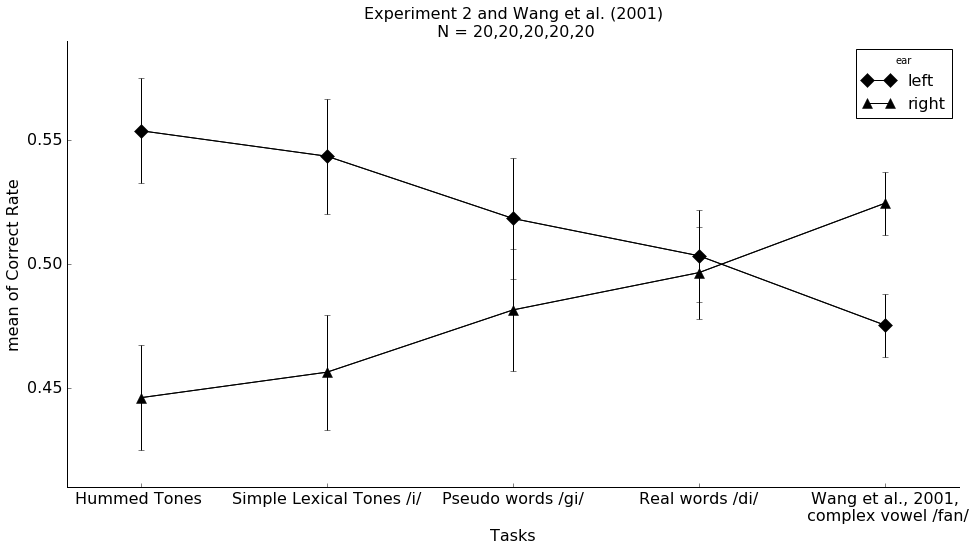

In [35]:
fig,ax = plt.subplots(figsize=(16,8))
fig = interaction_plot(df.group, df.ear, df.data,
             colors=['black','black'], markers=['D','^'], ms=10,ax=ax,
                     xlabel='Tasks',ylabel='Correct Rate')
ax.errorbar([1,2,3,4,5],df[df.ear=='left'].groupby('group').mean().values,
            df[df.ear=='left'].groupby('group').std().values/np.sqrt(20),color='black')
ax.errorbar([1,2,3,4,5],df[df.ear=='right'].groupby('group').mean().values,
            df[df.ear=='right'].groupby('group').std().values/np.sqrt(20),color='black')
ax.set(title='Experiment 2 and Wang et al. (2001)\n N = 20,20,20,20,20',xticks=[1,2,3,4,5],
      xticklabels=['Hummed Tones ','Simple Lexical Tones /i/','Pseudo words /gi/','Real words /di/\n',
                   'Wang et al., 2001,\n complex vowel /fan/'],
      )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
fig.savefig('2 way anova.png')

# Comment on figure: I feel this figure is telling the same story as the box plot but it is clearer that that is an interaction. 

# so I did a 2-way ANOVA, and it has a main effect on tasks and an interaction

In [45]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
df.group = df.group.map({ii:name for ii,name in enumerate(P)})
formula = 'data ~ group + ear + group:ear'
model = ols(formula,df).fit()
aov_table = anova_lm(model, typ=2)

In [48]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [49]:
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)

                 sum_sq     df             F    PR(>F)        eta_sq  omega_sq
group      3.698161e-30    4.0  1.101909e-28  1.000000  2.027320e-30 -0.018314
ear        7.155435e-02    1.0  8.528173e+00  0.003920  3.922587e-02  0.034468
group:ear  1.584415e-01    4.0  4.720946e+00  0.001181  8.685715e-02  0.068145
Residual   1.594166e+00  190.0           NaN       NaN           NaN       NaN


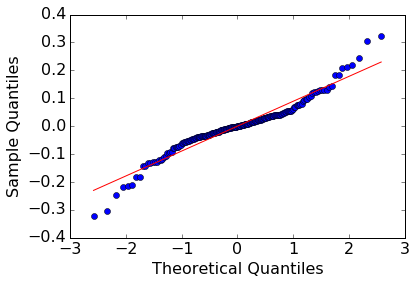

In [50]:
res = model.resid 
fig = sm.qqplot(res, line='s')
fig.savefig('residual.png')

In [6]:
import pyvttbl as pt
from collections import namedtuple

In [8]:
diff.shape

(5L, 20L)

In [11]:
Sub = namedtuple('Sub',['Sub_id','diff','tasks'])
df = pt.DataFrame()
P = ['Hummed Tones ','Simple Lexical Tones /i/','Pseudo words /gi/','Real words /di/\n']#,
                   #'Wang et al., 2001,\n complex vowel /fan/']
df = pt.DataFrame({'Laterality_Index':diff[:4].flatten(),'Tasks':np.repeat(P,20),
 'Sub_id':np.vstack((np.arange(1,21),np.arange(1,21),np.arange(1,21),np.arange(1,21))).flatten()})
#df['condition'] = df['Group'].apply(map({ii:name for ii,name in enumerate(P)}))

In [12]:
aov=df.anova('Laterality_Index',sub='Sub_id',wfactors=['Tasks'])

c:\Anaconda2\lib\site-packages\pyvttbl\stats\_anova.py:1240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return list(array(list(zeros((p-len(b))))+b)+1.)


# Sort of repeated measure ANOVA on laterality Index

In [13]:
print(aov)

Laterality_Index ~ Tasks

TESTS OF WITHIN SUBJECTS EFFECTS

Measure: Laterality_Index
   Source                           Type III    eps      df      MS       F     Sig.    et2_G   Obs.    SE     95% CI   lambda   Obs.  
                                       SS                                                                                        Power 
Tasks          Sphericity Assumed      0.127       -        3   0.042   1.229   0.308   0.043     20   0.042    0.083    1.293   0.131 
               Greenhouse-Geisser      0.127   0.817    2.451   0.052   1.229   0.307   0.043     20   0.042    0.083    1.293   0.122 
               Huynh-Feldt             0.127   0.817    2.451   0.052   1.229   0.307   0.043     20   0.042    0.083    1.293   0.122 
               Box                     0.127   0.333        1   0.127   1.229   0.281   0.043     20   0.042    0.083    1.293   0.096 
--------------------------------------------------------------------------------------------------

# sort of repeated measure ANOVA on ear effects

In [16]:
k = np.vstack((np.arange(1,21),np.arange(1,21),np.arange(1,21),np.arange(1,21))).flatten()
df = pt.DataFrame({'data':np.concatenate((grand_leftcol[:4,:].flatten(),grand_rightcol[:4,:].flatten())),
                   'group':np.concatenate((np.repeat(P,20),np.repeat(P,20))),
                  'ear':np.concatenate((np.repeat(['Left'],len(grand_leftcol[:4,:].flatten())),
                                        np.repeat(['Right'],len(grand_leftcol[:4,:].flatten())))),
'Sub_id':np.concatenate((k, k))})

In [17]:
df.box_plot('data',factors=['ear','group'])

In [18]:
aov = df.anova('data',sub='Sub_id',wfactors=['ear','group'])

In [19]:
print(aov)

data ~ ear * group

TESTS OF WITHIN SUBJECTS EFFECTS

Measure: data
   Source                           Type III     eps      df        MS         F     Sig.      et2_G     Obs.      SE        95% CI     lambda   Obs.  
                                       SS                                                                                                        Power 
ear            Sphericity Assumed       0.142       -        1       0.142   5.556   0.029       0.097     80       0.019       0.037   23.394   0.996 
               Greenhouse-Geisser       0.142       1        1       0.142   5.556   0.029       0.097     80       0.019       0.037   23.394   0.996 
               Huynh-Feldt              0.142       1        1       0.142   5.556   0.029       0.097     80       0.019       0.037   23.394   0.996 
               Box                      0.142       1        1       0.142   5.556   0.029       0.097     80       0.019       0.037   23.394   0.996 
--------------------